# <center>Определение порядка авторегрессии</center>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Алгоритм построения модели SARIMA рассмотрим на примере данных об объемах пассажирских авиаперевозок.

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col=0, parse_dates=True)

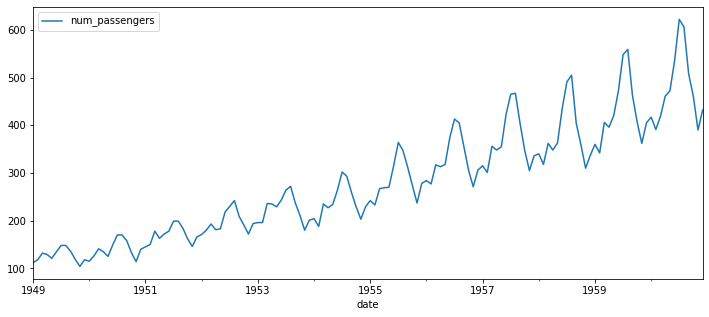

In [3]:
passengers.plot(figsize=(12,5))
plt.show()

Как было отмечено ранее, представленный временной ряд не является стационарным. В нем наблюдаются как тренд, так и сезонность. Кроме того, дисперсия на разных участках ряда не постоянна. Поэтому сначала выполним преобразование Бокса-Кокса.

## 1. Автокорреляция и частичная автокорреляция

Согласно теореме Вольда стационарный ряд можно описать моделью ARMA. Возникает вопрос: как определить порядок авторегрессии и порядок скользящего среднего? Для начала исходный ряд приводят к стационарному. После чего для определения порядка скользящего среднего прибегают к анализу коррелограммы полученного ряда.

In [4]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [5]:
passengers_transformed, lmbda = boxcox(passengers['num_passengers'])
y_transformation = pd.DataFrame(passengers['num_passengers'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [6]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.991880
После преобразования Бокса-Кокса: p=0.617162
После сезонного дифференцирования: p=0.052505
После дополнительного дифференцирования: p=0.000304


Рассмотрим коррелограмму полученного ряда.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

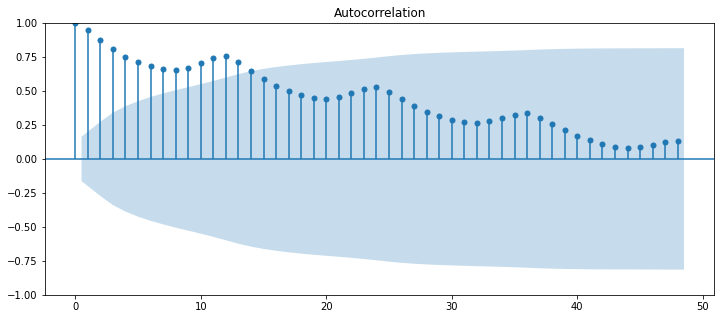

In [11]:
plot_acf(y_transformation['initial'].dropna(), lags=48)
plt.show()

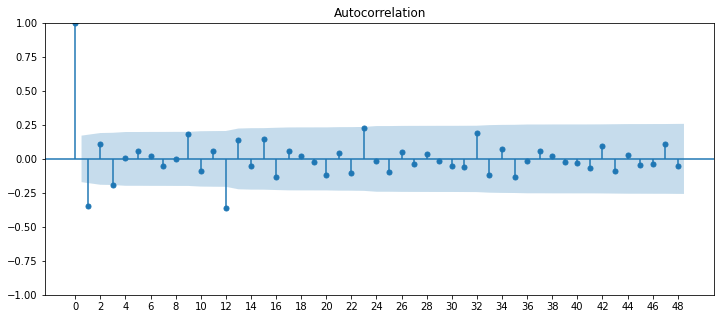

In [12]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

В качестве начального приближения гиперпараметра $q$ берется последний значимый лаг автокорреляции. Для примера выше последний значимый лаг равен 1. При лаге равном 2 значение автокорреляции попадает внутрь голубого "коридора", поэтому дальнейшие значения автокорреляции не рассматриваются, $q_0=1$.

Аналогичным образом определяется начальное приближение для сезонного порядка скользящего среднего $Q$. Необходимо определить последний значимый сезонный лаг автокорреляции. На графике выше последним значимым лагом является 12 (один сезонный период). Соответственно, порядок $Q_0=1$.

**Замечание по терминологии**: гиперпараметрами модели называют те параметры, которые задаются пользователем. Параметрами же называют подобранные путем минимизации функционала качества моделью коэффициенты. Функционалом качества может выступать, например, среднеквадратичная ошибка.

Т.е. когда речь идет о модели $ARIMA(p,d,q)$, гиперпараметрами являются $p$, $d$ и $q$, которые задаются вручную. Параметрами при этом являются коэффициенты $\alpha$, $\phi$ и $\theta$.

Для выбора начального приближения порядка авторегрессии $p$ прибегают к аналогичному методу, но рассматривают частичную автокорреляцию. Частичная автокорреляция &ndash; это автокорреляция после снятия авторегрессии предыдущего порядка. Для определения значения частичной автокорреляции с лагом 2 необходимо построить авторегрессию порядка 1 ($AR(1)$), вычесть эту авторегрессию из ряда и вычислить автокорреляцию на полученных остатках, т.е.:
$$\phi_{hh}=\begin{cases} r(y_{t+1},y_t), & h=1, \\ 
r(y_{t+h}-y_{t+h}^{h-1},y_t-y_t^{h-1}), & h\ge1, \end{cases}$$
где $y_t^{h-1} -$ авторегрессии следующего вида:
$$y_t^{h-1}=\beta_1 y_{t+1}+\beta_2 y_{t+2}+...+\beta_{h-1} y_{t+h-1},$$
$$y_{t+h}^{h-1}=\beta_1 y_{t+h-1}+\beta_2 y_{t+h-2}+...+\beta_{h-1} y_{t+1}.$$

Для построения графика частичной автокорреляции служит функция `plot_pacf`, которая находится в том же модуле `statsmodels.graphics.tsaplots`.

/home/levi/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


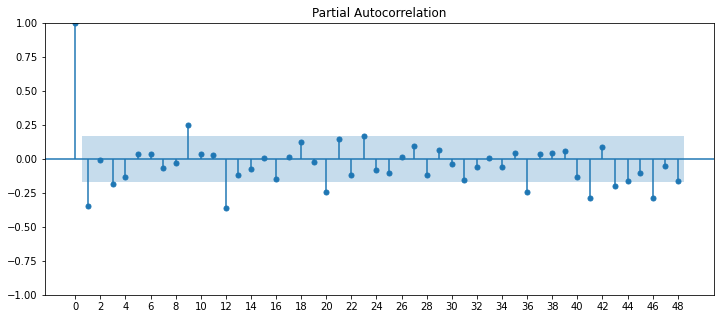

In [13]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг также равен 1, соответственно, $p_0=1$. При лаге 24 автокорреляцию можно считать значимой, однако слишком высокий порядок авторегрессии выбирать не рекомендуется. Возьмем $P_0=1$.

Для выбора оптимальных значений гиперпараметров $p$, $q$, $P$ и $Q$ необходимо построить соответствующие модели авторегрессии и оценить их качество. Поскольку вариантов достаточно много, обычно рассматриваются гиперпараметры в окрестности начального приближения  $p_0$, $q_0$, $P_0$, $Q_0$.

In [14]:
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [15]:
from itertools import product

In [18]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

36

Получили 36 возможных наборов гиперпараметров. Гиперпараметры модели нельзя выбирать методом максимального правдоподобия, поскольку с увеличением количества параметров значение функции правдоподобия $L$ растет. 

Поэтому для сравнения различных моделей применяется информационный критерий Акаике:
$$AIC=-2L+2k,$$
где $k$ &ndash; число параметров модели. Чем меньше значение данного критерия, тем лучше.

## 2. Построение модели SARIMA

Модель SARIMA можно найти в модуле `statsmodels.tsa.statespace.sarimax`. Процесс обучения модели (настройки параметров модели) аналогичен процессу обучения адаптивных методов.

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Обучим модель `SARIMA(1,1,0),(1,1,1)`. В качестве первого аргумента функции `SARIMAX` необходимо передать временной ряд. Чтобы определить порядки авторегрессии, дифференцирования и скользящего среднего необходимо передать их в виде кортежа в аргумент `order`. В данном случае передадим временной ряд, полученный после сезонного дифференцирования, поскольку обычное дифференцирование функция произведет самостоятельно.

In [22]:
model = SARIMAX(y_transformation['initial'],
                order=(1, 1, 0),
                seasonal_order=(1, 1, 1, 12)).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52820D+00    |proj g|=  8.80762D-02

At iterate    5    f=  3.51971D+00    |proj g|=  3.73866D-02

At iterate   10    f=  3.51572D+00    |proj g|=  2.13322D-03

At iterate   15    f=  3.51560D+00    |proj g|=  8.47925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   3.718D-07   3.516D+00
  F =   3.5155999996018727     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


Значение критерия Акаике:

In [23]:
model.aic

1020.4927998853393

Прогноз модели также можно получить с помощью функций `forecast` и `predict`.

In [24]:
model.params

ar.L1        -0.322589
ar.S.L12     -0.890945
ma.S.L12      0.791264
sigma2      131.525055
dtype: float64

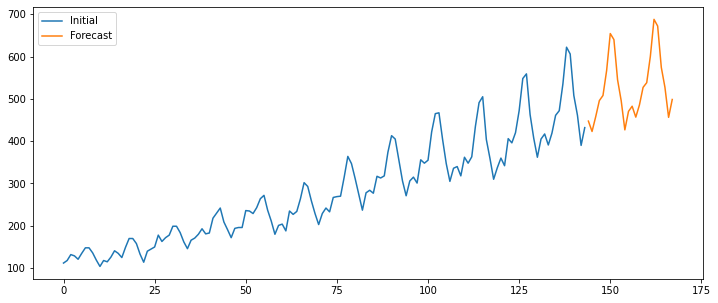

In [25]:
y_transformation['initial'].plot(figsize=(12,5))
model.forecast(24).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
<ol>
<li>Среди ранее полученных наборов гиперпараметров (<b>parameters_list</b>) найдите тот, для которого критерий Акаике минимален.</li>
    <p></p>
<li>С помощью функции <b>predict</b> получите прогноз на 36 точек вперед и отобразите его на графике.</li>
    <p></p>
</ol>
</div>

<p></p>
</div>

### Задание 1

**Подбор параметров**

In [36]:
d = 1
D = 1

aic_list = {}

for i in range(len(parameters_list)):
    p, q, P, Q = parameters_list[i]
    model = SARIMAX(y_transformation['initial'],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, 12)).fit()
    aic_list[i] = [parameters_list[i], model.aic]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57678D+00    |proj g|=  7.68840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   4.993D-07   3.575D+00
  F =   3.5746809311445245     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.5

 This problem is unconstrained.



At iterate    5    f=  3.56577D+00    |proj g|=  2.96837D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   2.651D-06   3.565D+00
  F =   3.5651119756870835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56515D+00    |proj g|=  1.18081D-02


 This problem is unconstrained.



At iterate    5    f=  3.56412D+00    |proj g|=  1.42138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   2.653D-06   3.564D+00
  F =   3.5639155251302159     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57052D+00    |proj g|=  2.42546D-02


 This problem is unconstrained.



At iterate    5    f=  3.56380D+00    |proj g|=  2.94645D-02

At iterate   10    f=  3.56301D+00    |proj g|=  3.86042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   3.113D-06   3.563D+00
  F =   3.5629431199749018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53032D+00    |proj g|=  5.18291D-03

At iterate    5    f=  3.53000D+00    |proj g|=  6.08433D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   7.792D-07   3.530D+00
  F =   3.5299957908075399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.52464D+00    |proj g|=  7.06645D-03

At iterate   10    f=  3.52431D+00    |proj g|=  7.82041D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   7.820D-08   3.524D+00
  F =   3.5243143212597592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52378D+00    |proj g|=  3.15399D-02

At iterate    5    f=  3.52245D+00    |proj g|=  1.08091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   3.627D-06   3.522D+00
  F =   3.5223088536689868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52836D+00    |proj g|=  8.08135D-02

At iterate    5    f=  3.52049D+00    |proj g|=  5.24672D-02

At iterate   10    f=  3.51599D+00    |proj g|=  2.79441D-03

At iterate   15    f=  3.51505D+00    |proj g|=  1.07806D-03

At iterate   20    f=  3.51503D+00    |proj g|=  2.91730D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   6.600D-07   3.515D+00
  F =   3.5150255192649325     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  3.53018D+00    |proj g|=  5.96547D-03

At iterate   10    f=  3.52995D+00    |proj g|=  6.66045D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   6.660D-07   3.530D+00
  F =   3.5299545837739053     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53125D+00    |proj g|=  8.74504D-02

At iterate    5    f=  3.52475D+00    |proj g|=  7.25885D-03

At iterate   10    f=  3.52431D+00    |proj g|=  3.78808D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   3.788D-07   3.524D+00
  F =   3.5243088345549802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  3.52277D+00    |proj g|=  8.01566D-03

At iterate   10    f=  3.52231D+00    |proj g|=  5.09046D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   5.090D-06   3.522D+00
  F =   3.5223068392377810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53137D+00    |proj g|=  8.78213D-02

At iterate    5    f=  3.52376D+00    |proj g|=  2.06540D-02

At iterate   10    f=  3.51589D+00    |proj g|=  2.09399D-03

At iterate   15    f=  3.51524D+00    |proj g|=  6.15005D-03

At iterate   20    f=  3.51502D+00    |proj g|=  7.97855D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   8.254D-06   3.515D+00
  F =   3.5150165986499067     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52916D+00    |proj g|=  1.70840D-03

At iterate    5    f=  3.52915D+00    |proj g|=  1.49881D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   8.580D-06   3.529D+00
  F =   3.5291438863545266     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.52406D+00    |proj g|=  2.80221D-03

At iterate   10    f=  3.52401D+00    |proj g|=  1.08765D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   3.940D-07   3.524D+00
  F =   3.5240058036870248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52346D+00    |proj g|=  3.67772D-02


 This problem is unconstrained.



At iterate    5    f=  3.52220D+00    |proj g|=  2.02268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   3.060D-06   3.522D+00
  F =   3.5221977376792934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52820D+00    |proj g|=  8.80762D-02


 This problem is unconstrained.



At iterate    5    f=  3.51971D+00    |proj g|=  3.73866D-02

At iterate   10    f=  3.51572D+00    |proj g|=  2.13322D-03

At iterate   15    f=  3.51560D+00    |proj g|=  8.47925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   3.718D-07   3.516D+00
  F =   3.5155999996018727     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52933D+00    |proj g|=  2.15319D-03


 This problem is unconstrained.



At iterate    5    f=  3.52916D+00    |proj g|=  4.52424D-03

At iterate   10    f=  3.52914D+00    |proj g|=  1.12268D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   1.091D-07   3.529D+00
  F =   3.5291433615554322     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52833D+00    |proj g|=  8.62776D-02

At iterate    5    f=  3.52395D+00    |proj g|=  2.06459D-03

At iterate   10    f=  3.52395D+00    |proj g|=  1.08450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   2.361D-06   3.524D+00
  F =   3.5239460045341096     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52380D+00    |proj g|=  3.63482D-02

At iterate    5    f=  3.52208D+00    |proj g|=  1.47020D-03

At iterate   10    f=  3.52207D+00    |proj g|=  6.92837D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   6.928D-06   3.522D+00
  F =   3.5220686693343914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  3.52337D+00    |proj g|=  3.73532D-02

At iterate   10    f=  3.51577D+00    |proj g|=  4.96154D-03

At iterate   15    f=  3.51498D+00    |proj g|=  1.97401D-03

At iterate   20    f=  3.51493D+00    |proj g|=  7.04749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   3.464D-05   3.515D+00
  F =   3.5149263657379288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53164D+00    |proj g|=  4.77096D-02

At iterate    5    f=  3.52992D+00    |proj g|=  7.11901D-03

At iterate   10    f=  3.52865D+00    |proj g|=  9.02340D-03

At iterate   15    f=  3.52833D+00    |proj g|=  3.62704D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   1.475D-06   3.528D+00
  F =   3.5283348193389870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  3.52483D+00    |proj g|=  3.80132D-03

At iterate   10    f=  3.52386D+00    |proj g|=  4.86554D-03

At iterate   15    f=  3.52337D+00    |proj g|=  3.74230D-03

At iterate   20    f=  3.52333D+00    |proj g|=  8.35154D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   8.352D-06   3.523D+00
  F =   3.5233253443159640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52580D+00    |proj g|=  5.19148D-02

At iterate    5    f=  3.52268D+00    |proj g|=  8.63883D-03

At iterate   10    f=  3.52199D+00    |proj g|=  3.92309D-03

At iterate   15    f=  3.52150D+00    |proj g|=  1.30404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   8.338D-06   3.521D+00
  F =   3.5214962709669582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  3.52437D+00    |proj g|=  1.27551D-02

At iterate   10    f=  3.51541D+00    |proj g|=  4.39399D-03

At iterate   15    f=  3.51436D+00    |proj g|=  6.84375D-04

At iterate   20    f=  3.51432D+00    |proj g|=  1.05522D-03

At iterate   25    f=  3.51431D+00    |proj g|=  1.10624D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   3.696D-06   3.514D+00
  F =   3.5143103294921030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52919D+00    |proj g|=  2.26201D-03

At iterate    5    f=  3.52915D+00    |proj g|=  3.21644D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   2.718D-06   3.529D+00
  F =   3.5291436219145709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.52407D+00    |proj g|=  3.71496D-03

At iterate   10    f=  3.52397D+00    |proj g|=  9.59299D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   9.593D-06   3.524D+00
  F =   3.5239741049379103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52355D+00    |proj g|=  3.66304D-02


 This problem is unconstrained.



At iterate    5    f=  3.52219D+00    |proj g|=  4.41693D-03

At iterate   10    f=  3.52213D+00    |proj g|=  1.15423D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.154D-06   3.522D+00
  F =   3.5221277877547283     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52826D+00    |proj g|=  8.76640D-02


 This problem is unconstrained.



At iterate    5    f=  3.52006D+00    |proj g|=  4.42970D-02

At iterate   10    f=  3.51546D+00    |proj g|=  1.72128D-03

At iterate   15    f=  3.51525D+00    |proj g|=  3.47365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.496D-05   3.515D+00
  F =   3.5152441029989632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57610D+00    |proj g|=  3.04448D-01

At iterate    5    f=  3.52912D+00    |proj g|=  2.12219D-03

At iterate   10    f=  3.52819D+00    |proj g|=  7.65533D-03

At iterate   15    f=  3.52185D+00    |proj g|=  2.59446D-02

At iterate   20    f=  3.51065D+00    |proj g|=  2.82501D-02

At iterate   25    f=  3.50647D+00    |proj g|=  9.68125D-04

At iterate   30    f=  3.50641D+00    |proj g|=  8.57705D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56624D+00    |proj g|=  2.72456D-01


 This problem is unconstrained.



At iterate    5    f=  3.52393D+00    |proj g|=  5.80872D-03

At iterate   10    f=  3.52151D+00    |proj g|=  2.40153D-02

At iterate   15    f=  3.50389D+00    |proj g|=  1.53660D-02

At iterate   20    f=  3.50126D+00    |proj g|=  7.60546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   4.779D-06   3.501D+00
  F =   3.5012481840173231     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56462D+00    |proj g|=  2.81396D-01

At iterate    5    f=  3.52221D+00    |proj g|=  2.80105D-03

At iterate   10    f=  3.52070D+00    |proj g|=  8.38077D-03

At iterate   15    f=  3.51568D+00    |proj g|=  3.09758D-02

At iterate   20    f=  3.50564D+00    |proj g|=  2.55445D-02

At iterate   25    f=  3.49971D+00    |proj g|=  2.01511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56629D+00    |proj g|=  2.72265D-01

At iterate    5    f=  3.52407D+00    |proj g|=  1.61655D-02

At iterate   10    f=  3.51415D+00    |proj g|=  4.81631D-03

At iterate   15    f=  3.50708D+00    |proj g|=  2.21564D-02

At iterate   20    f=  3.49754D+00    |proj g|=  4.75906D-03

At iterate   25    f=  3.49442D+00    |proj g|=  4.63307D-04

At iterate   30    f=  3.49440D+00    |proj g|=  3.12354D-04

At iterate   35    f=  3.49425D+00    |proj g|=  4.91089D-03

At iterate   40    f=  3.49392D+00    |proj g|=  4.16294D-04

At iterate   45    f=  3.49392D+00    |proj g|=  1.08800D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52376D+00    |proj g|=  5.09807D-02

At iterate    5    f=  3.51468D+00    |proj g|=  1.63527D-02

At iterate   10    f=  3.50706D+00    |proj g|=  9.97977D-03

At iterate   15    f=  3.50462D+00    |proj g|=  5.92927D-03

At iterate   20    f=  3.50448D+00    |proj g|=  2.29797D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   3.072D-06   3.504D+00
  F =   3.5044798777860797     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52286D+00    |proj g|=  8.40730D-02

At iterate    5    f=  3.51094D+00    |proj g|=  1.10231D-02

At iterate   10    f=  3.50236D+00    |proj g|=  2.04177D-02

At iterate   15    f=  3.50094D+00    |proj g|=  7.95690D-03

At iterate   20    f=  3.49979D+00    |proj g|=  1.10293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   2.602D-05   3.500D+00
  F =   3.4997746156039344     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51856D+00    |proj g|=  6.59873D-02

At iterate    5    f=  3.50899D+00    |proj g|=  9.12086D-03

At iterate   10    f=  3.50199D+00    |proj g|=  1.44204D-02

At iterate   15    f=  3.49957D+00    |proj g|=  3.35100D-03

At iterate   20    f=  3.49845D+00    |proj g|=  1.86283D-03

At iterate   25    f=  3.49842D+00    |proj g|=  1.27327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  3.50838D+00    |proj g|=  1.86363D-02

At iterate   10    f=  3.50252D+00    |proj g|=  2.67933D-02

At iterate   15    f=  3.49491D+00    |proj g|=  5.74111D-03

At iterate   20    f=  3.49358D+00    |proj g|=  8.93360D-03

At iterate   25    f=  3.49323D+00    |proj g|=  1.83535D-04

At iterate   30    f=  3.49322D+00    |proj g|=  6.18891D-04

At iterate   35    f=  3.49322D+00    |proj g|=  5.79873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     41      1     0     0   5.799D-05   3.493D+00
  F =   3.4932208496726438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [39]:
aic_list

{0: [(0, 0, 0, 0), 1031.508108169623],
 1: [(0, 0, 0, 1), 1030.75224899788],
 2: [(0, 0, 1, 0), 1030.4076712375022],
 3: [(0, 0, 1, 1), 1032.1276185527718],
 4: [(0, 1, 0, 0), 1020.6387877525715],
 5: [(0, 1, 0, 1), 1021.0025245228106],
 6: [(0, 1, 1, 0), 1020.4249498566681],
 7: [(0, 1, 1, 1), 1020.3273495483005],
 8: [(0, 2, 0, 0), 1022.6269201268847],
 9: [(0, 2, 0, 1), 1023.0009443518343],
 10: [(0, 2, 1, 0), 1022.424369700481],
 11: [(0, 2, 1, 1), 1022.3247804111732],
 12: [(1, 0, 0, 0), 1020.3934392701036],
 13: [(1, 0, 0, 1), 1020.9136714618631],
 14: [(1, 0, 1, 0), 1020.3929484516365],
 15: [(1, 0, 1, 1), 1020.4927998853393],
 16: [(1, 1, 0, 0), 1022.3932881279644],
 17: [(1, 1, 0, 1), 1022.8964493058236],
 18: [(1, 1, 1, 0), 1022.3557767683047],
 19: [(1, 1, 1, 1), 1022.2987933325235],
 20: [(1, 2, 0, 0), 1024.1604279696282],
 21: [(1, 2, 0, 1), 1024.7176991629976],
 22: [(1, 2, 1, 0), 1024.190926038484],
 23: [(1, 2, 1, 1), 1024.1213748937257],
 24: [(2, 0, 0, 0), 1022.393363

In [68]:
start = y_transformation['initial'].index[-1]
end = start + 36

In [69]:
min(aic_list.items(), key=lambda x: x[1][-1])

(28, [(2, 1, 0, 0), 1017.8467849913025])

In [70]:
aic_list[28][0]

(2, 1, 0, 0)

In [71]:
d = 1
D = 1
p, q, P, Q = aic_list[28][0]

In [72]:
model = SARIMAX(y_transformation['initial'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, 12)).fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57610D+00    |proj g|=  3.04448D-01

At iterate    5    f=  3.52912D+00    |proj g|=  2.12219D-03

At iterate   10    f=  3.52819D+00    |proj g|=  7.65533D-03

At iterate   15    f=  3.52185D+00    |proj g|=  2.59446D-02

At iterate   20    f=  3.51065D+00    |proj g|=  2.82501D-02

At iterate   25    f=  3.50647D+00    |proj g|=  9.68125D-04

At iterate   30    f=  3.50641D+00    |proj g|=  8.57705D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

**Построен прогноза**

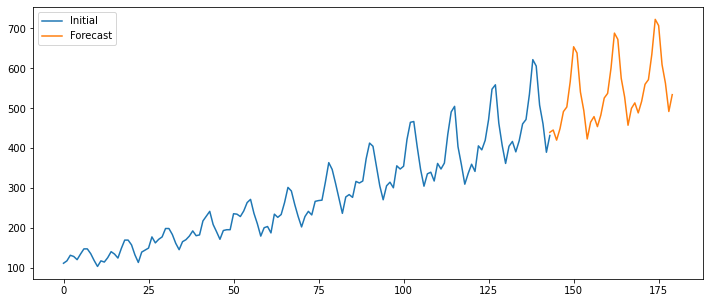

In [74]:
y_transformation['initial'].plot(figsize=(12,5))
model.predict(start=start,end=end).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

<div class="alert alert-success">
    <h3> Задание 2</h3>
</div>

**Подбор параметров**

In [78]:
wine = pd.read_csv('data/monthly-australian-wine-sales.csv', index_col=0, parse_dates=True)

In [80]:
wine.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


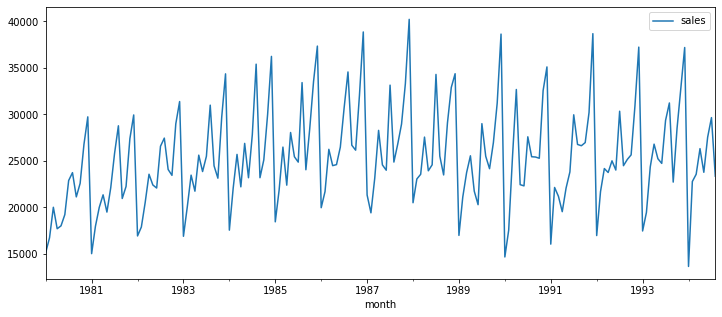

In [79]:
wine.plot(figsize=(12,5))
plt.show()

In [82]:
wine_transformed, lmbda = boxcox(wine['sales'])
y_transformation = pd.DataFrame(wine['sales'].values, columns=['initial'])
y_transformation['transformed'] = wine_transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [83]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.051161
После преобразования Бокса-Кокса: p=0.029565
После сезонного дифференцирования: p=0.128317
После дополнительного дифференцирования: p=0.000002


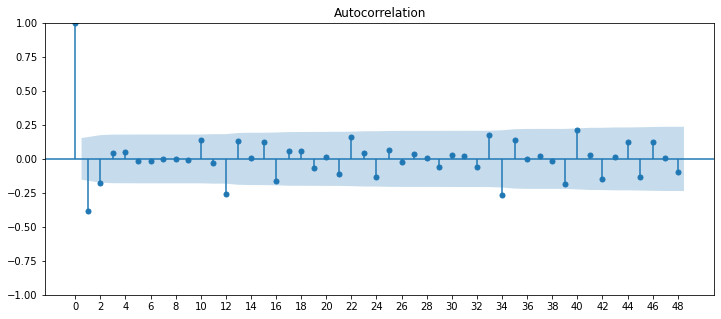

In [88]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


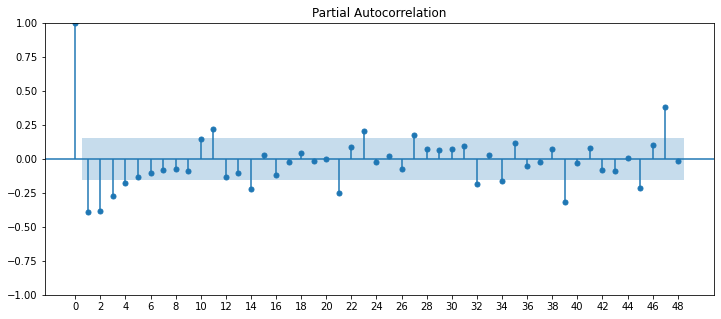

In [89]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

In [90]:
p = range(0, 5)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [91]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

60

In [92]:
d = 1
D = 1

aic_list1 = {}

for i in range(len(parameters_list)):
    p, q, P, Q = parameters_list[i]
    model = SARIMAX(y_transformation['initial'],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, 12)).fit()
    aic_list1[i] = [parameters_list[i], model.aic]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89176D+00    |proj g|=  2.14964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   1.491D-06   8.890D+00
  F =   8.8903640749273229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.8

 This problem is unconstrained.



At iterate    5    f=  8.85663D+00    |proj g|=  2.06128D-04

At iterate   10    f=  8.85660D+00    |proj g|=  4.57987D-03

At iterate   15    f=  8.85403D+00    |proj g|=  4.83720D-02

At iterate   20    f=  8.84637D+00    |proj g|=  5.52584D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     24      1     0     0   2.672D-07   8.846D+00
  F =   8.8463677948544515     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   7.322D-06   8.859D+00
  F =   8.8585047372173840     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86511D+00    |proj g|=  7.63402D-02

At iterate    5    f=  8.85324D+00    |proj g|=  8.07095D-02

At iterate   10    f=  8.84282D+00    |proj g|=  1.28782D-04

At iterate   15    f=  8.84280D+00    |proj g|=  3.89303D-03

At iterate   20    f=  8.84049D+00    |proj g|=  4.81178D-02

At iterate   25    f=  8.83470D+00    |proj g|=  2.53800D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.76550D+00    |proj g|=  2.07450D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   2.075D-05   8.766D+00
  F =   8.7655011161558196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70169D+00    |proj g|=  8.22342D-02


 This problem is unconstrained.



At iterate    5    f=  8.69412D+00    |proj g|=  2.81064D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   2.811D-05   8.694D+00
  F =   8.6941178407511170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71118D+00    |proj g|=  2.69925D-02


 This problem is unconstrained.



At iterate    5    f=  8.70918D+00    |proj g|=  1.82883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   1.829D-05   8.709D+00
  F =   8.7091791717158564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71028D+00    |proj g|=  5.27150D-02


 This problem is unconstrained.



At iterate    5    f=  8.69168D+00    |proj g|=  5.70964D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.965D-05   8.692D+00
  F =   8.6916394353280637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95420D+00    |proj g|=  6.21681D-01

At iterate    5    f=  8.75538D+00    |proj g|=  6.83232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   4.101D-05   8.755D+00
  F =   8.7553483093851572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88543D+00    |proj g|=  6.05014D-01


 This problem is unconstrained.



At iterate    5    f=  8.68618D+00    |proj g|=  2.10122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      8      1     0     0   4.663D-06   8.686D+00
  F =   8.6861727605667287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.90897D+00    |proj g|=  6.22130D-01

At iterate    5    f=  8.70094D+00    |proj g|=  3.91863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      8      1     0     0   5.330D-06   8.701D+00
  F =   8.7009313372760673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.90685D+00    |proj g|=  6.20949D-01


 This problem is unconstrained.



At iterate    5    f=  8.69480D+00    |proj g|=  3.85889D-02

At iterate   10    f=  8.68251D+00    |proj g|=  4.38402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     14      1     0     0   7.132D-06   8.682D+00
  F =   8.6824965250282968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83104D+00    |proj g|=  9.93806D-02

At iterate    5    f=  8.82499D+00    |proj g|=  7.00417D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   7.004D-06   8.825D+00
  F =   8.8249943296435678     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  8.76934D+00    |proj g|=  6.16641D-05

At iterate   10    f=  8.76933D+00    |proj g|=  2.34401D-03

At iterate   15    f=  8.76848D+00    |proj g|=  2.07398D-02

At iterate   20    f=  8.76679D+00    |proj g|=  4.11070D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   4.496D-06   8.767D+00
  F =   8.7667935744416567     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.78376D+00    |proj g|=  1.87809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.878D-05   8.784D+00
  F =   8.7837618322038171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78686D+00    |proj g|=  6.01138D-02


 This problem is unconstrained.



At iterate    5    f=  8.76362D+00    |proj g|=  2.20777D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   3.293D-05   8.763D+00
  F =   8.7632126601795619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79007D+00    |proj g|=  1.59321D-01


 This problem is unconstrained.



At iterate    5    f=  8.75868D+00    |proj g|=  9.64208D-02

At iterate   10    f=  8.75415D+00    |proj g|=  1.81792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   1.818D-05   8.754D+00
  F =   8.7541485823723786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74060D+00    |proj g|=  1.33426D-01


 This problem is unconstrained.



At iterate    5    f=  8.70622D+00    |proj g|=  1.21243D-01

At iterate   10    f=  8.68890D+00    |proj g|=  2.81857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   2.379D-05   8.689D+00
  F =   8.6888966298552770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74889D+00    |proj g|=  1.16884D-01

At iterate    5    f=  8.71125D+00    |proj g|=  1.00298D-01

At iterate   10    f=  8.70296D+00    |proj g|=  5.96676D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     19      1     0     0   1.450D-05   8.703D+00
  F =   8.7029583959192571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.69799D+00    |proj g|=  2.45370D-02

At iterate   10    f=  8.68607D+00    |proj g|=  2.29351D-02

At iterate   15    f=  8.68560D+00    |proj g|=  3.83412D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   3.834D-05   8.686D+00
  F =   8.6856007295092397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83411D+00    |proj g|=  1.08516D-01

At iterate    5    f=  8.75695D+00    |proj g|=  2.60269D-02

At iterate   10    f=  8.75664D+00    |proj g|=  4.42940D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.944D-05   8.757D+00
  F =   8.7566031943069209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.68550D+00    |proj g|=  1.96821D-02

At iterate   10    f=  8.68386D+00    |proj g|=  1.91813D-02

At iterate   15    f=  8.68302D+00    |proj g|=  7.49488D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   2.611D-05   8.683D+00
  F =   8.6830213981102258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78154D+00    |proj g|=  8.79464D-02


 This problem is unconstrained.



At iterate    5    f=  8.70059D+00    |proj g|=  3.14410D-02

At iterate   10    f=  8.69968D+00    |proj g|=  1.64030D-02

At iterate   15    f=  8.69892D+00    |proj g|=  3.53816D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   1.904D-05   8.699D+00
  F =   8.6989229182046177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78089D+00    |proj g|=  8.83949D-02


 This problem is unconstrained.



At iterate    5    f=  8.69062D+00    |proj g|=  2.78084D-02

At iterate   10    f=  8.68096D+00    |proj g|=  5.38331D-03

At iterate   15    f=  8.68041D+00    |proj g|=  1.15631D-02

At iterate   20    f=  8.67998D+00    |proj g|=  1.12690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   2.089D-06   8.680D+00
  F =   8.6799833878875621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80860D+00    |proj g|=  1.85195D-01

At iterate    5    f=  8.78317D+00    |proj g|=  2.78261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   2.783D-05   8.783D+00
  F =   8.7831687212778782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72915D+00    |proj g|=  1.19312D-01

At iterate    5    f=  8.71012D+00    |proj g|=  5.71998D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   2.127D-05   8.710D+00
  F =   8.7101239869480533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  8.72799D+00    |proj g|=  8.63505D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   8.635D-06   8.728D+00
  F =   8.7279850922828359     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73975D+00    |proj g|=  1.15883D-01


 This problem is unconstrained.



At iterate    5    f=  8.71072D+00    |proj g|=  5.41651D-02

At iterate   10    f=  8.70676D+00    |proj g|=  5.76401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   2.371D-05   8.707D+00
  F =   8.7067630530520734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77227D+00    |proj g|=  2.04908D-01


 This problem is unconstrained.



At iterate    5    f=  8.75211D+00    |proj g|=  2.23614D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   2.244D-05   8.752D+00
  F =   8.7520946145264684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70357D+00    |proj g|=  1.41004D-01

At iterate    5    f=  8.68477D+00    |proj g|=  8.28544D-03

At iterate   10    f=  8.68446D+00    |proj g|=  2.15977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   2.160D-05   8.684D+00
  F =   8.6844589816761353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.69870D+00    |proj g|=  1.12204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.236D-05   8.699D+00
  F =   8.6985341579593811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71028D+00    |proj g|=  1.25800D-01


 This problem is unconstrained.



At iterate    5    f=  8.68833D+00    |proj g|=  6.71246D-02

At iterate   10    f=  8.68146D+00    |proj g|=  1.72896D-03

At iterate   15    f=  8.68142D+00    |proj g|=  2.35282D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   2.353D-05   8.681D+00
  F =   8.6814207886356627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82160D+00    |proj g|=  2.67440D-01

At iterate    5    f=  8.75947D+00    |proj g|=  4.59225D-02

At iterate   10    f=  8.75686D+00    |proj g|=  1.74509D-03

At iterate   15    f=  8.75618D+00    |proj g|=  8.74531D-03

At iterate   20    f=  8.75612D+00    |proj g|=  1.97332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   5.006D-05   8.756D+00
  F =   8.7561239379260929     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.68376D+00    |proj g|=  2.43245D-02

At iterate   10    f=  8.68286D+00    |proj g|=  1.09441D-03

At iterate   15    f=  8.68276D+00    |proj g|=  6.21823D-03

At iterate   20    f=  8.68271D+00    |proj g|=  2.36231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   2.362D-05   8.683D+00
  F =   8.6827058166751208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75747D+00    |proj g|=  2.04465D-01

At iterate    5    f=  8.70052D+00    |proj g|=  5.18290D-02

At iterate   10    f=  8.69848D+00    |proj g|=  4.42467D-04

At iterate   15    f=  8.69844D+00    |proj g|=  5.80767D-03

At iterate   20    f=  8.69840D+00    |proj g|=  1.03744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   6.188D-05   8.698D+00
  F =   8.6984036218912806     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75687D+00    |proj g|=  2.06058D-01

At iterate    5    f=  8.68692D+00    |proj g|=  4.62588D-02

At iterate   10    f=  8.68001D+00    |proj g|=  2.34295D-02

At iterate   15    f=  8.67974D+00    |proj g|=  5.94652D-04

At iterate   20    f=  8.67973D+00    |proj g|=  1.23714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   3.181D-05   8.680D+00
  F =   8.6797257795377476     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.76423D+00    |proj g|=  3.92792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   3.928D-05   8.764D+00
  F =   8.7642315228424810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72819D+00    |proj g|=  1.79965D-01

At iterate    5    f=  8.69538D+00    |proj g|=  2.75956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   1.607D-05   8.695D+00
  F =   8.6953836539234040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73664D+00    |proj g|=  1.73360D-01

At iterate    5    f=  8.71049D+00    |proj g|=  3.19288D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   3.322D-06   8.710D+00
  F =   8.7104866641905208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73590D+00    |proj g|=  1.74187D-01

At iterate    5    f=  8.69871D+00    |proj g|=  8.08380D-02

At iterate   10    f=  8.69113D+00    |proj g|=  4.82858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   1.070D-05   8.691D+00
  F =   8.6911295413122964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77932D+00    |proj g|=  2.53262D-01

At iterate    5    f=  8.75282D+00    |proj g|=  1.90277D-02

At iterate   10    f=  8.75201D+00    |proj g|=  2.23755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   2.238D-05   8.752D+00
  F =   8.7520103762321657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.68589D+00    |proj g|=  1.05900D-02

At iterate   10    f=  8.68420D+00    |proj g|=  8.07901D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   3.545D-05   8.684D+00
  F =   8.6842026201145650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71435D+00    |proj g|=  1.53429D-01


 This problem is unconstrained.



At iterate    5    f=  8.69898D+00    |proj g|=  1.37764D-02

At iterate   10    f=  8.69852D+00    |proj g|=  1.23331D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     14      1     0     0   1.233D-05   8.699D+00
  F =   8.6985179407176769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71369D+00    |proj g|=  1.54752D-01


 This problem is unconstrained.



At iterate    5    f=  8.68844D+00    |proj g|=  6.77719D-02

At iterate   10    f=  8.68137D+00    |proj g|=  2.31680D-03

At iterate   15    f=  8.68124D+00    |proj g|=  2.35255D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     17      1     0     0   2.353D-05   8.681D+00
  F =   8.6812429071883805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96676D+00    |proj g|=  6.47825D-01

At iterate    5    f=  8.75772D+00    |proj g|=  7.69662D-03

At iterate   10    f=  8.75691D+00    |proj g|=  9.61775D-05



/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     12      1     0     0   5.485D-05   8.757D+00
  F =   8.7569112887463536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89491D+00    |proj g|=  6.30453D-01

At iterate    5    f=  8.68388D+00    |proj g|=  1.34765D-02

At iterate   10    f=  8.68276D+00    |proj g|=  3.62357D-04

At iterate   15    f=  8.68269D+00    |proj g|=  3.92419D-03

At itera

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91938D+00    |proj g|=  6.48330D-01


 This problem is unconstrained.



At iterate    5    f=  8.69959D+00    |proj g|=  1.20072D-02

At iterate   10    f=  8.69857D+00    |proj g|=  2.32729D-04

At iterate   15    f=  8.69855D+00    |proj g|=  4.30920D-03

At iterate   20    f=  8.69851D+00    |proj g|=  7.43402D-04

At iterate   25    f=  8.69851D+00    |proj g|=  4.35206D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     30      1     0     0   2.274D-05   8.699D+00
  F =   8.6985074065325492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91719D+00    |proj g|=  6.47098D-01


 This problem is unconstrained.



At iterate    5    f=  8.69260D+00    |proj g|=  3.48422D-02

At iterate   10    f=  8.68003D+00    |proj g|=  5.24347D-03

At iterate   15    f=  8.67969D+00    |proj g|=  5.77208D-04

At iterate   20    f=  8.67968D+00    |proj g|=  9.24886D-04

At iterate   25    f=  8.67961D+00    |proj g|=  1.30565D-03

At iterate   30    f=  8.67961D+00    |proj g|=  1.57932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     38      1     0     0   4.034D-05   8.680D+00
  F =   8.6796053155199679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81347D+00    |proj g|=  2.93445D-01

At iterate    5    f=  8.76040D+00    |proj g|=  5.59064D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   4.685D-05   8.760D+00
  F =   8.7604021017829385     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  8.68634D+00    |proj g|=  1.23488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7      9      1     0     0   8.570D-06   8.686D+00
  F =   8.6863378151972626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73455D+00    |proj g|=  2.02764D-01


 This problem is unconstrained.



At iterate    5    f=  8.70153D+00    |proj g|=  9.21061D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      8      1     0     0   6.862D-06   8.702D+00
  F =   8.7015336317065159     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73411D+00    |proj g|=  2.04135D-01

At iterate    5    f=  8.68884D+00    |proj g|=  6.71709D-02

At iterate   10    f=  8.68359D+00    |proj g|=  4.15021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     14      1     0     0   1.460D-05   8.684D+00
  F =   8.6835922903814247     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.75493D+00    |proj g|=  6.40789D-03

At iterate   10    f=  8.75371D+00    |proj g|=  1.38284D-02

At iterate   15    f=  8.75138D+00    |proj g|=  2.95279D-02

At iterate   20    f=  8.75054D+00    |proj g|=  3.30910D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   3.725D-05   8.751D+00
  F =   8.7505366652401460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74238D+00    |proj g|=  1.97485D-01

At iterate    5    f=  8.68336D+00    |proj g|=  1.88614D-03

At iterate   10    f=  8.68309D+00    |proj g|=  4.22107D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     15      1     0     0   2.881D-05   8.683D+00
  F =   8.6830759548216250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.69844D+00    |proj g|=  2.29316D-03

At iterate   10    f=  8.69813D+00    |proj g|=  5.26345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     17      1     0     0   5.834D-06   8.698D+00
  F =   8.6981016017207082     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74690D+00    |proj g|=  1.92015D-01


 This problem is unconstrained.



At iterate    5    f=  8.68279D+00    |proj g|=  3.61986D-02

At iterate   10    f=  8.68039D+00    |proj g|=  2.70368D-03

At iterate   15    f=  8.68010D+00    |proj g|=  1.09129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     23      1     0     0   1.280D-05   8.680D+00
  F =   8.6801027334907577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96716D+00    |proj g|=  6.48635D-01


 This problem is unconstrained.



At iterate    5    f=  8.75707D+00    |proj g|=  1.84305D-03

At iterate   10    f=  8.75696D+00    |proj g|=  5.55380D-03

At iterate   15    f=  8.75693D+00    |proj g|=  6.22525D-04

At iterate   20    f=  8.75685D+00    |proj g|=  1.23430D-02

At iterate   25    f=  8.75632D+00    |proj g|=  2.03879D-02

At iterate   30    f=  8.75401D+00    |proj g|=  2.50540D-02

At iterate   35    f=  8.75217D+00    |proj g|=  2.35338D-02

At iterate   40    f=  8.75178D+00    |proj g|=  4.98295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     46      1     0     0   5.259D-05   8.752D+00
  F =   8.75178115725

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89522D+00    |proj g|=  6.31241D-01

At iterate    5    f=  8.68351D+00    |proj g|=  6.60093D-03

At iterate   10    f=  8.68270D+00    |proj g|=  6.40702D-03

At iterate   15    f=  8.68264D+00    |proj g|=  9.81712D-04

At iterate   20    f=  8.68258D+00    |proj g|=  1.95580D-03

At iterate   25    f=  8.68257D+00    |proj g|=  5.71660D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     28      1     0     0   

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91972D+00    |proj g|=  6.49141D-01


 This problem is unconstrained.



At iterate    5    f=  8.69930D+00    |proj g|=  6.15224D-03

At iterate   10    f=  8.69859D+00    |proj g|=  1.16164D-02

At iterate   15    f=  8.69844D+00    |proj g|=  4.33996D-04

At iterate   20    f=  8.69840D+00    |proj g|=  1.49145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     27      1     0     0   4.940D-05   8.698D+00
  F =   8.6983902970521303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91752D+00    |proj g|=  6.47908D-01


 This problem is unconstrained.



At iterate    5    f=  8.69254D+00    |proj g|=  2.70684D-02

At iterate   10    f=  8.67993D+00    |proj g|=  1.75933D-02

At iterate   15    f=  8.67967D+00    |proj g|=  6.01446D-04

At iterate   20    f=  8.67966D+00    |proj g|=  2.29823D-04

At iterate   25    f=  8.67964D+00    |proj g|=  3.45397D-03

At iterate   30    f=  8.67960D+00    |proj g|=  5.94713D-04

At iterate   35    f=  8.67960D+00    |proj g|=  2.92447D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     38      1     0     0   2.924D-05   8.680D+00
  F =   8.6795991182981052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [93]:
aic_list1

{0: [(0, 0, 0, 0), 3131.408154374418],
 1: [(0, 0, 0, 1), 3117.921463788767],
 2: [(0, 0, 1, 0), 3122.193667500519],
 3: [(0, 0, 1, 1), 3115.814305936129],
 4: [(0, 1, 0, 0), 3089.4563928868483],
 5: [(0, 1, 0, 1), 3066.3294799443934],
 6: [(0, 1, 1, 0), 3071.6310684439813],
 7: [(0, 1, 1, 1), 3067.4570812354787],
 8: [(0, 2, 0, 0), 3087.882604903575],
 9: [(0, 2, 0, 1), 3065.5328117194886],
 10: [(0, 2, 1, 0), 3070.7278307211755],
 11: [(0, 2, 1, 1), 3066.2387768099607],
 12: [(1, 0, 0, 0), 3110.398004034536],
 13: [(1, 0, 0, 1), 3091.9113382034634],
 14: [(1, 0, 1, 0), 3097.8841649357437],
 15: [(1, 0, 1, 1), 3092.650856383206],
 16: [(1, 1, 0, 0), 3087.460300995077],
 17: [(1, 1, 0, 1), 3066.491613709057],
 18: [(1, 1, 1, 0), 3071.4413553635786],
 19: [(1, 1, 1, 1), 3067.331456787252],
 20: [(1, 2, 0, 0), 3090.324324396036],
 21: [(1, 2, 0, 1), 3066.4235321347996],
 22: [(1, 2, 1, 0), 3072.0208672080253],
 23: [(1, 2, 1, 1), 3067.3541525364217],
 24: [(2, 0, 0, 0), 3097.675389889813

In [94]:
start = y_transformation['initial'].index[-1]
end = start + 36

In [95]:
min(aic_list1.items(), key=lambda x: x[1][-1])

(9, [(0, 2, 0, 1), 3065.5328117194886])

In [96]:
d = 1
D = 1
p, q, P, Q = aic_list[9][0]

In [97]:
model = SARIMAX(y_transformation['initial'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, 12)).fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88543D+00    |proj g|=  6.05014D-01

At iterate    5    f=  8.68618D+00    |proj g|=  2.10122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      8      1     0     0   4.663D-06   8.686D+00
  F =   8.6861727605667287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


**Построение прогноза**

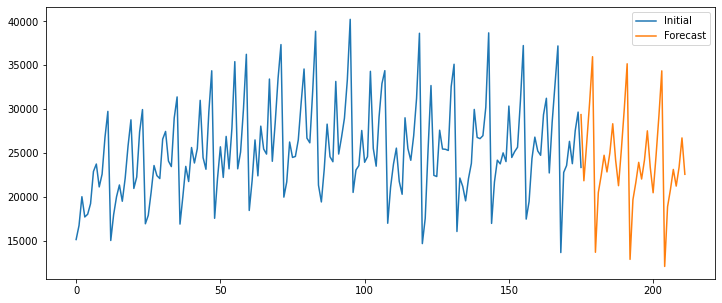

In [98]:
y_transformation['initial'].plot(figsize=(12,5))
model.predict(start=start,end=end).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()